## Importing libraries

In [1]:
# Input and Output from Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Stage 1 - Deep Learning

## Get the data

In [2]:
# Generate input - output data

def generate_xt(num_samples=10):
    x = np.random.uniform(-1, 1, num_samples) # Input random
    # x = np.random.randint(-100, 100, num_samples) # Input random
    t = np.zeros(num_samples)
    
    t[0] = 0   # Inisialisasi
    
    for k in range(1, num_samples):
        t[k] = 1 / (1 + t[k-1]**2) + 0.25*x[k] - 0.3*x[k-1]
    
    df = pd.DataFrame({"x": x, "t": t})
    return df

df = generate_xt(30002)
print(df)

              x         t
0     -0.852127  0.000000
1     -0.374682  1.161968
2     -0.891909  0.314929
3      0.359902  1.267317
4      0.601272  0.426064
...         ...       ...
29997 -0.114932  0.416894
29998 -0.578400  0.741813
29999 -0.942321  0.582982
30000 -0.721895  0.848565
30001 -0.465248  0.681631

[30002 rows x 2 columns]


In [3]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t-1)" : df["t"].shift(1),
    "t(t-2)" : df["t"].shift(2),
    "t(t)"   : df["t"]   # target
})  # 3 lagged inputs and 2 lagged outputs

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       x(t)    x(t-1)    x(t-2)    t(t-1)    t(t-2)      t(t)
0 -0.891909 -0.374682 -0.852127  1.161968  0.000000  0.314929
1  0.359902 -0.891909 -0.374682  0.314929  1.161968  1.267317
2  0.601272  0.359902 -0.891909  1.267317  0.314929  0.426064
3  0.056379  0.601272  0.359902  0.426064  1.267317  0.680073
4 -0.564278  0.056379  0.601272  0.680073  0.426064  0.525778
(30000, 6)


In [4]:
# dataset
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)", "t(t-1)", "t(t-2)"]].values   # input size=6
T = df_lagged[["t(t)"]].values    # target

# check size of dataset
print(X.shape, T.shape)

(30000, 5) (30000, 1)


## Splitting the dataset

In [5]:
def split_dataset_seq(X, T):
    """
    Membagi dataset 30.000 sample secara berurutan:
    - Train: 15.000 pertama
    - Val: 5.000 terakhir dari train + 5.000 setelah train
    - Test: 10.000 terakhir
    """
    assert len(X) == len(T), "Jumlah X dan T harus sama"
    assert len(X) == 30000, "Dataset harus 30.000 sample sesuai aturan"

    # Train 15.000 pertama
    X_train = X[:15000]
    T_train = T[:15000]

    # Validation = 5000 terakhir train + 5000 setelah train
    X_val = np.concatenate([X[10000:15000], X[15000:20000]])
    T_val = np.concatenate([T[10000:15000], T[15000:20000]])

    # Test = 10000 terakhir
    X_test = X[20000:30000]
    T_test = T[20000:30000]

    return X_train, T_train, X_val, T_val, X_test, T_test

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)


Train: (15000, 5) (15000, 1)
Val  : (10000, 5) (10000, 1)
Test : (10000, 5) (10000, 1)


## Neural Network Model

In [7]:
from MyKeras.models import NN
from MyKeras.layers import Dense
from MyKeras.callbacks import EarlyStopping

# create MLP model
model = NN()
model.add(Dense(units=10, activation='sigmoid', input_shape=X_train.shape[1]))
model.add(Dense(units=20, activation='sigmoid'))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', lr=0.001)

## Training and Validation

In [8]:
# training
early_stopping_criteria = EarlyStopping(patience=100, restore_best_weights=True)
history = model.fit(X_train, T_train, X_val, T_val, epochs=10000, tol=1e-3, callbacks=[early_stopping_criteria])

print("Last train loss:", history["train_loss"][-1])
print("Last val loss  :", history["val_loss"][-1])

# saving weights from previous training
weights = model.get_best_weights()

TypeError: unsupported format string passed to function.__format__

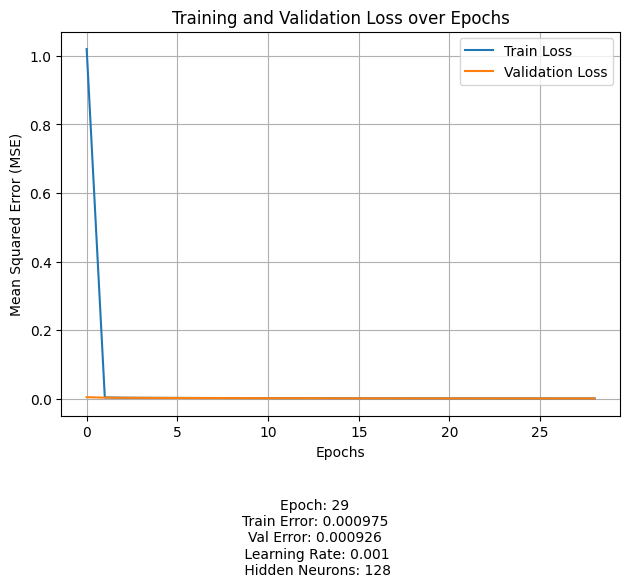

In [9]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}\n Learning Rate: {model.lr}\n Hidden Neurons: {model.NH}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

# Stage 2

## Getting the Data

In [10]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t)"   : df["t"]   # target
})  # 3 lagged inputs and 2 lagged outputs

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       x(t)    x(t-1)    x(t-2)      t(t)
0  0.039394  0.924020  0.818789  0.240012
1 -0.989299  0.039394  0.924020  0.686389
2  0.054230 -0.989299  0.039394  0.990097
3  0.986999  0.054230 -0.989299  0.735457
4 -0.479442  0.986999  0.054230  0.233013
(30000, 4)


## Splitting the dataset

In [11]:
# dataset
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)"]].values   # 100 sampel, input size=6
T = df_lagged[["t(t)"]].values    # target

# check size of dataset
print(X.shape, T.shape)

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)

(30000, 3) (30000, 1)
Train: (15000, 3) (15000, 1)
Val  : (10000, 3) (10000, 1)
Test : (10000, 3) (10000, 1)


## Training and validation

In [18]:
# buat model
y_lags = 2          # lags for feedback
model = NN(input_size=X_train.shape[1]+y_lags, hidden_size=128, output_size=1, lr=0.001)
model.set_weights(weights)

# training
history = model.fit_narx(X_train, T_train, X_val, T_val, epochs=1000, tol=1e-3, patience=20, y_lags=y_lags)

print("Last train loss:", history["train_loss"][-1])
print("Last val loss  :", history["val_loss"][-1])

Training stopped at epoch 10, train_loss=0.000989
Last train loss: 0.0009887055839530715
Last val loss  : 0.0009595285182644304


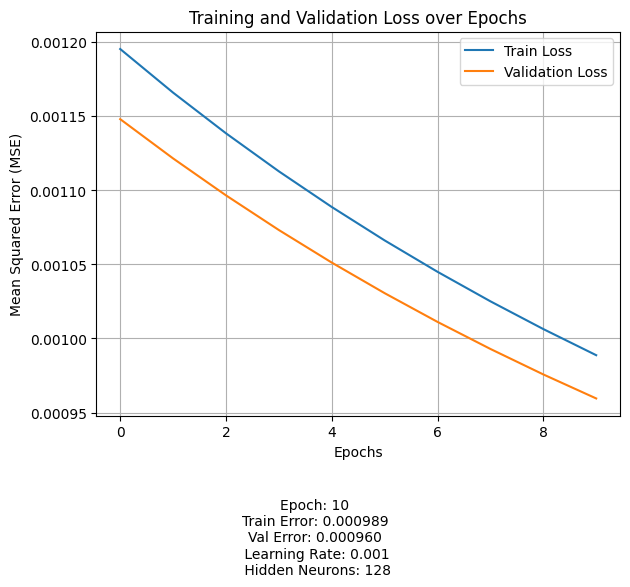

In [19]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}\n Learning Rate: {model.lr}\n Hidden Neurons: {model.NH}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [22]:
# testing
predictions = model.predict_narx(X_test, y_lags = y_lags)
mse_test = np.mean((T_test - predictions)**2)

print("Predictions:", predictions.flatten())
print("Test MSE:", mse_test)

Predictions: [0.27575022 0.42679331 0.97826591 ... 0.75145293 0.65651305 0.99915334]
Test MSE: 0.001022886759697706


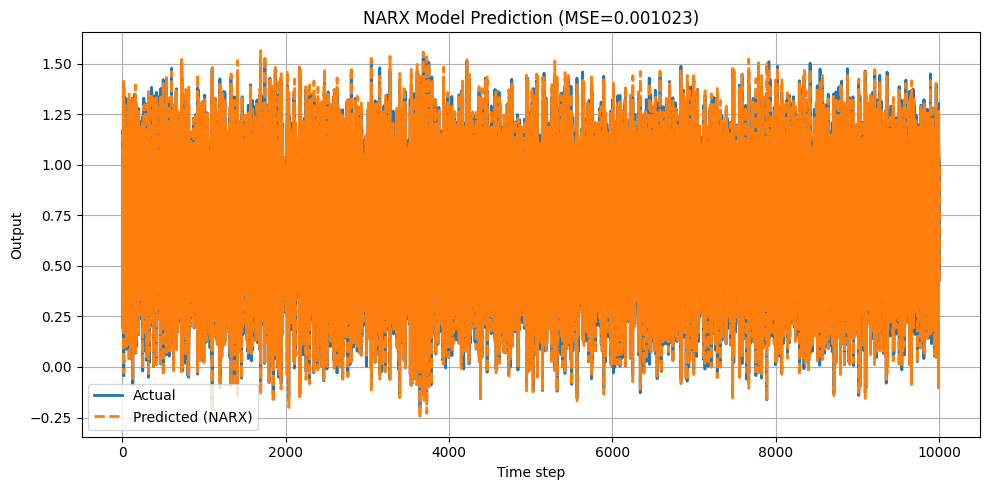

In [23]:
# --- prediction vs target plot ---
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(predictions, label='Predicted (NARX)', linestyle='--', linewidth=2)
plt.title(f'NARX Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
print(model.get_weights())

{'v': array([[ 3.80729012e-01,  9.46681800e-01,  7.11031743e-01,
         6.47182502e-01,  1.28265958e-01,  1.59395172e-01,
         1.10723669e-01,  8.68644669e-01,  6.16399434e-01,
         7.20543481e-01,  1.65835164e-02,  9.73305807e-01,
         8.51026639e-01,  2.16973773e-01,  1.60980382e-01,
         1.75096861e-01,  2.96140665e-01,  4.86766079e-01,
         4.35822671e-01,  2.83788017e-01,  6.03722638e-01,
         1.53584968e-01,  2.64028952e-01,  3.39810960e-01,
         4.55573926e-01,  8.09202493e-01,  9.64899507e-02,
         5.79857011e-01,  6.22386371e-01,  5.42494164e-02,
         6.27791434e-01,  1.99149597e-01,  9.35455250e-02,
         9.47174783e-01,  9.84597427e-01,  8.18996605e-01,
         3.05695502e-01,  1.34871282e-01,  6.86099101e-01,
         4.19857765e-01,  1.13216557e-01,  4.43671641e-01,
         6.86427960e-02,  9.27398360e-01,  1.80799951e-01,
         6.77760715e-01,  3.20323694e-01,  5.21757244e-01,
         5.48220850e-01,  1.86346150e-01,  9.34695